In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 drehrsxe


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-drehrsxe:best, 314.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.7


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                              | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 1/2604 [00:01<49:54,  1.15s/it]

  0%|▎                                                                                                                                                     | 6/2604 [00:01<07:00,  6.17it/s]

  0%|▋                                                                                                                                                    | 11/2604 [00:01<03:38, 11.86it/s]

  1%|▉                                                                                                                                                    | 16/2604 [00:01<02:24, 17.86it/s]

  1%|█▏                                                                                                                                                   | 21/2604 [00:01<01:48, 23.73it/s]

  1%|█▍                                                                                                                                                   | 26/2604 [00:01<01:28, 29.09it/s]

  1%|█▊                                                                                                                                                   | 31/2604 [00:01<01:16, 33.70it/s]

  1%|██                                                                                                                                                   | 36/2604 [00:01<01:08, 37.51it/s]

  2%|██▎                                                                                                                                                  | 41/2604 [00:01<01:03, 40.57it/s]

  2%|██▋                                                                                                                                                  | 46/2604 [00:02<00:59, 42.93it/s]

  2%|██▉                                                                                                                                                  | 51/2604 [00:02<00:57, 44.72it/s]

  2%|███▏                                                                                                                                                 | 56/2604 [00:02<00:55, 46.04it/s]

  2%|███▍                                                                                                                                                 | 61/2604 [00:02<00:54, 46.98it/s]

  3%|███▊                                                                                                                                                 | 66/2604 [00:02<00:53, 47.57it/s]

  3%|████                                                                                                                                                 | 71/2604 [00:02<00:52, 48.07it/s]

  3%|████▎                                                                                                                                                | 76/2604 [00:02<00:52, 48.44it/s]

  3%|████▋                                                                                                                                                | 81/2604 [00:02<00:51, 48.71it/s]

  3%|████▉                                                                                                                                                | 86/2604 [00:02<00:51, 48.89it/s]

  3%|█████▏                                                                                                                                               | 91/2604 [00:03<00:51, 49.03it/s]

  4%|█████▍                                                                                                                                               | 96/2604 [00:03<00:51, 49.07it/s]

  4%|█████▋                                                                                                                                              | 101/2604 [00:03<00:50, 49.14it/s]

  4%|██████                                                                                                                                              | 106/2604 [00:03<00:50, 49.20it/s]

  4%|██████▎                                                                                                                                             | 111/2604 [00:03<00:50, 49.25it/s]

  4%|██████▌                                                                                                                                             | 116/2604 [00:03<00:50, 49.27it/s]

  5%|██████▉                                                                                                                                             | 121/2604 [00:03<00:50, 49.27it/s]

  5%|███████▏                                                                                                                                            | 126/2604 [00:03<00:50, 49.15it/s]

  5%|███████▍                                                                                                                                            | 131/2604 [00:03<00:50, 49.21it/s]

  5%|███████▋                                                                                                                                            | 136/2604 [00:03<00:50, 49.18it/s]

  5%|████████                                                                                                                                            | 141/2604 [00:04<00:50, 49.09it/s]

  6%|████████▎                                                                                                                                           | 146/2604 [00:04<00:50, 49.14it/s]

  6%|████████▌                                                                                                                                           | 151/2604 [00:04<00:49, 49.20it/s]

  6%|████████▊                                                                                                                                           | 156/2604 [00:04<00:49, 49.23it/s]

  6%|█████████▏                                                                                                                                          | 161/2604 [00:04<00:49, 49.23it/s]

  6%|█████████▍                                                                                                                                          | 166/2604 [00:04<00:49, 49.27it/s]

  7%|█████████▋                                                                                                                                          | 171/2604 [00:04<00:49, 49.30it/s]

  7%|██████████                                                                                                                                          | 176/2604 [00:04<00:49, 49.30it/s]

  7%|██████████▎                                                                                                                                         | 181/2604 [00:04<00:49, 49.23it/s]

  7%|██████████▌                                                                                                                                         | 186/2604 [00:04<00:49, 49.24it/s]

  7%|██████████▊                                                                                                                                         | 191/2604 [00:05<00:48, 49.27it/s]

  8%|███████████▏                                                                                                                                        | 196/2604 [00:05<00:49, 48.65it/s]

  8%|███████████▍                                                                                                                                        | 201/2604 [00:05<00:49, 48.84it/s]

  8%|███████████▋                                                                                                                                        | 206/2604 [00:05<00:48, 48.95it/s]

  8%|███████████▉                                                                                                                                        | 211/2604 [00:05<00:48, 49.04it/s]

  8%|████████████▎                                                                                                                                       | 216/2604 [00:05<00:48, 49.03it/s]

  8%|████████████▌                                                                                                                                       | 221/2604 [00:05<00:48, 49.06it/s]

  9%|████████████▊                                                                                                                                       | 226/2604 [00:05<00:48, 49.13it/s]

  9%|█████████████▏                                                                                                                                      | 231/2604 [00:05<00:48, 49.15it/s]

  9%|█████████████▍                                                                                                                                      | 236/2604 [00:05<00:48, 49.19it/s]

  9%|█████████████▋                                                                                                                                      | 241/2604 [00:06<00:48, 49.16it/s]

  9%|█████████████▉                                                                                                                                      | 246/2604 [00:06<00:47, 49.22it/s]

 10%|██████████████▎                                                                                                                                     | 251/2604 [00:06<00:47, 49.26it/s]

 10%|██████████████▌                                                                                                                                     | 256/2604 [00:06<00:47, 49.32it/s]

 10%|██████████████▊                                                                                                                                     | 261/2604 [00:06<00:47, 49.30it/s]

 10%|███████████████                                                                                                                                     | 266/2604 [00:06<00:47, 49.30it/s]

 10%|███████████████▍                                                                                                                                    | 271/2604 [00:06<00:47, 49.28it/s]

 11%|███████████████▋                                                                                                                                    | 276/2604 [00:06<00:47, 49.29it/s]

 11%|███████████████▉                                                                                                                                    | 281/2604 [00:06<00:47, 49.25it/s]

 11%|████████████████▎                                                                                                                                   | 286/2604 [00:06<00:46, 49.36it/s]

 11%|████████████████▌                                                                                                                                   | 291/2604 [00:07<00:46, 49.31it/s]

 11%|████████████████▊                                                                                                                                   | 296/2604 [00:07<00:46, 49.31it/s]

 12%|█████████████████                                                                                                                                   | 301/2604 [00:07<00:46, 49.34it/s]

 12%|█████████████████▍                                                                                                                                  | 306/2604 [00:07<00:46, 49.19it/s]

 12%|█████████████████▋                                                                                                                                  | 311/2604 [00:07<00:46, 49.22it/s]

 12%|█████████████████▉                                                                                                                                  | 316/2604 [00:07<00:46, 49.27it/s]

 12%|██████████████████▏                                                                                                                                 | 321/2604 [00:07<00:46, 49.26it/s]

 13%|██████████████████▌                                                                                                                                 | 326/2604 [00:07<00:46, 49.23it/s]

 13%|██████████████████▊                                                                                                                                 | 331/2604 [00:07<00:46, 49.25it/s]

 13%|███████████████████                                                                                                                                 | 336/2604 [00:07<00:46, 49.24it/s]

 13%|███████████████████▍                                                                                                                                | 341/2604 [00:08<00:45, 49.26it/s]

 13%|███████████████████▋                                                                                                                                | 346/2604 [00:08<00:45, 49.26it/s]

 13%|███████████████████▉                                                                                                                                | 351/2604 [00:08<00:45, 49.27it/s]

 14%|████████████████████▏                                                                                                                               | 356/2604 [00:08<00:45, 49.34it/s]

 14%|████████████████████▌                                                                                                                               | 361/2604 [00:08<00:45, 49.37it/s]

 14%|████████████████████▊                                                                                                                               | 366/2604 [00:08<00:45, 49.28it/s]

 14%|█████████████████████                                                                                                                               | 371/2604 [00:08<00:45, 49.28it/s]

 14%|█████████████████████▎                                                                                                                              | 376/2604 [00:08<00:45, 49.26it/s]

 15%|█████████████████████▋                                                                                                                              | 381/2604 [00:08<00:45, 49.28it/s]

 15%|█████████████████████▉                                                                                                                              | 386/2604 [00:08<00:45, 49.24it/s]

 15%|██████████████████████▏                                                                                                                             | 391/2604 [00:09<00:44, 49.26it/s]

 15%|██████████████████████▌                                                                                                                             | 396/2604 [00:09<00:44, 49.24it/s]

 15%|██████████████████████▊                                                                                                                             | 401/2604 [00:09<00:44, 49.23it/s]

 16%|███████████████████████                                                                                                                             | 406/2604 [00:09<00:44, 49.35it/s]

 16%|███████████████████████▎                                                                                                                            | 411/2604 [00:09<00:44, 49.30it/s]

 16%|███████████████████████▋                                                                                                                            | 416/2604 [00:09<00:44, 49.35it/s]

 16%|███████████████████████▉                                                                                                                            | 421/2604 [00:09<00:44, 49.31it/s]

 16%|████████████████████████▏                                                                                                                           | 426/2604 [00:09<00:44, 49.34it/s]

 17%|████████████████████████▍                                                                                                                           | 431/2604 [00:09<00:44, 49.34it/s]

 17%|████████████████████████▊                                                                                                                           | 436/2604 [00:10<00:43, 49.29it/s]

 17%|█████████████████████████                                                                                                                           | 441/2604 [00:10<00:43, 49.29it/s]

 17%|█████████████████████████▎                                                                                                                          | 446/2604 [00:10<00:43, 49.33it/s]

 17%|█████████████████████████▋                                                                                                                          | 451/2604 [00:10<00:43, 49.32it/s]

 18%|█████████████████████████▉                                                                                                                          | 456/2604 [00:10<00:43, 49.38it/s]

 18%|██████████████████████████▏                                                                                                                         | 461/2604 [00:10<00:43, 49.47it/s]

 18%|██████████████████████████▍                                                                                                                         | 466/2604 [00:10<00:43, 49.43it/s]

 18%|██████████████████████████▊                                                                                                                         | 471/2604 [00:10<00:43, 49.42it/s]

 18%|███████████████████████████                                                                                                                         | 476/2604 [00:10<00:43, 49.37it/s]

 18%|███████████████████████████▎                                                                                                                        | 481/2604 [00:10<00:43, 49.35it/s]

 19%|███████████████████████████▌                                                                                                                        | 486/2604 [00:11<00:42, 49.32it/s]

 19%|███████████████████████████▉                                                                                                                        | 491/2604 [00:11<00:42, 49.23it/s]

 19%|████████████████████████████▏                                                                                                                       | 496/2604 [00:11<00:42, 49.26it/s]

 19%|████████████████████████████▍                                                                                                                       | 501/2604 [00:11<00:42, 49.28it/s]

 19%|████████████████████████████▊                                                                                                                       | 506/2604 [00:11<00:42, 49.28it/s]

 20%|█████████████████████████████                                                                                                                       | 511/2604 [00:11<00:42, 49.21it/s]

 20%|█████████████████████████████▎                                                                                                                      | 516/2604 [00:11<00:42, 49.26it/s]

 20%|█████████████████████████████▌                                                                                                                      | 521/2604 [00:11<00:42, 49.26it/s]

 20%|█████████████████████████████▉                                                                                                                      | 526/2604 [00:11<00:42, 49.26it/s]

 20%|██████████████████████████████▏                                                                                                                     | 531/2604 [00:11<00:42, 49.28it/s]

 21%|██████████████████████████████▍                                                                                                                     | 536/2604 [00:12<00:41, 49.31it/s]

 21%|██████████████████████████████▋                                                                                                                     | 541/2604 [00:12<00:41, 49.13it/s]

 21%|███████████████████████████████                                                                                                                     | 546/2604 [00:12<00:41, 49.22it/s]

 21%|███████████████████████████████▎                                                                                                                    | 551/2604 [00:12<00:41, 49.27it/s]

 21%|███████████████████████████████▌                                                                                                                    | 556/2604 [00:12<00:41, 49.24it/s]

 22%|███████████████████████████████▉                                                                                                                    | 561/2604 [00:12<00:41, 49.28it/s]

 22%|████████████████████████████████▏                                                                                                                   | 566/2604 [00:12<00:41, 49.29it/s]

 22%|████████████████████████████████▍                                                                                                                   | 571/2604 [00:12<00:41, 49.33it/s]

 22%|████████████████████████████████▋                                                                                                                   | 576/2604 [00:12<00:41, 49.21it/s]

 22%|█████████████████████████████████                                                                                                                   | 581/2604 [00:12<00:41, 49.31it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 586/2604 [00:13<00:40, 49.29it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 591/2604 [00:13<00:40, 49.30it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 596/2604 [00:13<00:40, 49.36it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 601/2604 [00:13<00:40, 49.28it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 606/2604 [00:13<00:40, 49.26it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 611/2604 [00:13<00:40, 49.29it/s]

 24%|███████████████████████████████████                                                                                                                 | 616/2604 [00:13<00:40, 49.29it/s]

 24%|███████████████████████████████████▎                                                                                                                | 621/2604 [00:13<00:40, 49.30it/s]

 24%|███████████████████████████████████▌                                                                                                                | 626/2604 [00:13<00:40, 49.33it/s]

 24%|███████████████████████████████████▊                                                                                                                | 631/2604 [00:13<00:40, 49.16it/s]

 24%|████████████████████████████████████▏                                                                                                               | 636/2604 [00:14<00:40, 49.14it/s]

 25%|████████████████████████████████████▍                                                                                                               | 641/2604 [00:14<00:39, 49.23it/s]

 25%|████████████████████████████████████▋                                                                                                               | 646/2604 [00:14<00:39, 49.21it/s]

 25%|█████████████████████████████████████                                                                                                               | 651/2604 [00:14<00:39, 49.39it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 656/2604 [00:14<00:39, 49.42it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 661/2604 [00:14<00:39, 49.45it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 666/2604 [00:14<00:39, 49.32it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 671/2604 [00:14<00:39, 49.35it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 676/2604 [00:14<00:39, 49.36it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 681/2604 [00:14<00:38, 49.33it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 686/2604 [00:15<00:38, 49.29it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 691/2604 [00:15<00:38, 49.31it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 696/2604 [00:15<00:38, 49.29it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 701/2604 [00:15<00:38, 49.34it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 706/2604 [00:15<00:38, 49.39it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 711/2604 [00:15<00:38, 49.26it/s]

 27%|████████████████████████████████████████▋                                                                                                           | 716/2604 [00:15<00:38, 49.27it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 721/2604 [00:15<00:38, 49.21it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 726/2604 [00:15<00:38, 49.25it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 731/2604 [00:15<00:37, 49.36it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 736/2604 [00:16<00:37, 49.38it/s]

 28%|██████████████████████████████████████████                                                                                                          | 741/2604 [00:16<00:37, 49.32it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 746/2604 [00:16<00:37, 49.31it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 751/2604 [00:16<00:37, 49.32it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 756/2604 [00:16<00:37, 49.32it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 761/2604 [00:16<00:37, 49.31it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 766/2604 [00:16<00:37, 49.18it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 771/2604 [00:16<00:37, 49.05it/s]

 30%|████████████████████████████████████████████                                                                                                        | 776/2604 [00:16<00:37, 49.14it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 781/2604 [00:17<00:37, 49.20it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 786/2604 [00:17<00:36, 49.16it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 791/2604 [00:17<00:36, 49.07it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 796/2604 [00:17<00:36, 49.14it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 801/2604 [00:17<00:36, 49.21it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 806/2604 [00:17<00:36, 49.23it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 811/2604 [00:17<00:36, 49.29it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 816/2604 [00:17<00:36, 49.29it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 821/2604 [00:17<00:36, 49.16it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 826/2604 [00:17<00:36, 49.31it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 831/2604 [00:18<00:35, 49.40it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 836/2604 [00:18<00:35, 49.31it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 841/2604 [00:18<00:35, 49.20it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 846/2604 [00:18<00:35, 49.17it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 851/2604 [00:18<00:35, 49.22it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 856/2604 [00:18<00:35, 49.28it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 861/2604 [00:18<00:35, 49.33it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 866/2604 [00:18<00:35, 49.31it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                  | 871/2604 [00:18<00:35, 49.22it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 876/2604 [00:18<00:35, 49.23it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 881/2604 [00:19<00:35, 49.18it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 886/2604 [00:19<00:34, 49.23it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 891/2604 [00:19<00:34, 49.22it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                 | 896/2604 [00:19<00:34, 49.10it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 901/2604 [00:19<00:34, 49.17it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 906/2604 [00:19<00:34, 49.24it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 911/2604 [00:19<00:34, 49.31it/s]

 35%|████████████████████████████████████████████████████                                                                                                | 916/2604 [00:19<00:34, 49.31it/s]

 35%|████████████████████████████████████████████████████▎                                                                                               | 921/2604 [00:19<00:34, 49.27it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 926/2604 [00:19<00:34, 49.15it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 931/2604 [00:20<00:33, 49.22it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                              | 936/2604 [00:20<00:33, 49.24it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                              | 941/2604 [00:20<00:33, 49.29it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 946/2604 [00:20<00:33, 49.30it/s]

 37%|██████████████████████████████████████████████████████                                                                                              | 951/2604 [00:20<00:33, 49.32it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 956/2604 [00:20<00:33, 49.36it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 961/2604 [00:20<00:33, 49.31it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                             | 966/2604 [00:20<00:33, 49.31it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 971/2604 [00:20<00:33, 49.30it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 976/2604 [00:20<00:33, 49.29it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 981/2604 [00:21<00:32, 49.36it/s]

 38%|████████████████████████████████████████████████████████                                                                                            | 986/2604 [00:21<00:32, 49.31it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 991/2604 [00:21<00:32, 49.24it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 996/2604 [00:21<00:32, 49.20it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                          | 1001/2604 [00:21<00:32, 49.13it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 1006/2604 [00:21<00:32, 49.21it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 1011/2604 [00:21<00:32, 49.29it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 1016/2604 [00:21<00:32, 49.29it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                         | 1021/2604 [00:21<00:32, 49.30it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                         | 1026/2604 [00:21<00:32, 49.24it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 1031/2604 [00:22<00:31, 49.18it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 1036/2604 [00:22<00:31, 49.22it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1041/2604 [00:22<00:31, 49.17it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1046/2604 [00:22<00:31, 49.15it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1051/2604 [00:22<00:31, 49.19it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                       | 1056/2604 [00:22<00:31, 49.24it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                       | 1061/2604 [00:22<00:31, 49.26it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                      | 1066/2604 [00:22<00:31, 49.33it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                      | 1071/2604 [00:22<00:31, 49.32it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 1076/2604 [00:23<00:31, 49.10it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1081/2604 [00:23<00:31, 49.05it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1086/2604 [00:23<00:30, 49.11it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 1091/2604 [00:23<00:30, 49.06it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1096/2604 [00:23<00:30, 48.95it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 1101/2604 [00:23<00:30, 48.90it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 1106/2604 [00:23<00:30, 48.81it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 1111/2604 [00:23<00:30, 48.94it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1116/2604 [00:23<00:30, 49.06it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 1121/2604 [00:23<00:30, 49.16it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1126/2604 [00:24<00:30, 49.17it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 1131/2604 [00:24<00:30, 49.07it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 1136/2604 [00:24<00:29, 49.12it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 1141/2604 [00:24<00:29, 49.16it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 1146/2604 [00:24<00:29, 49.25it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 1151/2604 [00:24<00:29, 49.28it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1156/2604 [00:24<00:29, 49.30it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 1161/2604 [00:24<00:29, 49.12it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 1166/2604 [00:24<00:29, 49.11it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 1171/2604 [00:24<00:29, 48.99it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 1176/2604 [00:25<00:29, 49.10it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 1181/2604 [00:25<00:28, 49.10it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                                | 1186/2604 [00:25<00:28, 49.11it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                               | 1191/2604 [00:25<00:28, 49.25it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 1196/2604 [00:25<00:28, 49.33it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 1201/2604 [00:25<00:28, 49.28it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 1206/2604 [00:25<00:28, 49.23it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                              | 1211/2604 [00:25<00:28, 49.14it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                              | 1216/2604 [00:25<00:28, 49.19it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 1221/2604 [00:25<00:28, 49.26it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 1226/2604 [00:26<00:27, 49.31it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 1231/2604 [00:26<00:27, 49.31it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                             | 1236/2604 [00:26<00:27, 49.26it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1241/2604 [00:26<00:27, 49.27it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 1246/2604 [00:26<00:27, 49.31it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1251/2604 [00:26<00:27, 49.30it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                            | 1256/2604 [00:26<00:27, 49.30it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 1261/2604 [00:26<00:27, 49.34it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 1266/2604 [00:26<00:27, 49.28it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1271/2604 [00:26<00:27, 49.29it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 1276/2604 [00:27<00:26, 49.27it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1281/2604 [00:27<00:26, 49.31it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 1286/2604 [00:27<00:26, 49.30it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 1291/2604 [00:27<00:26, 49.35it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 1296/2604 [00:27<00:26, 49.38it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                         | 1301/2604 [00:27<00:26, 49.43it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                         | 1306/2604 [00:27<00:26, 49.29it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1311/2604 [00:27<00:26, 49.24it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1316/2604 [00:27<00:26, 49.08it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                        | 1322/2604 [00:28<00:25, 49.35it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 1327/2604 [00:28<00:25, 49.33it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                       | 1332/2604 [00:28<00:25, 49.30it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                       | 1337/2604 [00:28<00:25, 49.21it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1342/2604 [00:28<00:25, 49.18it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 1347/2604 [00:28<00:25, 49.27it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 1352/2604 [00:28<00:25, 49.32it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 1357/2604 [00:28<00:25, 49.35it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 1362/2604 [00:28<00:25, 49.24it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                     | 1367/2604 [00:28<00:25, 49.22it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                     | 1372/2604 [00:29<00:25, 49.15it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 1377/2604 [00:29<00:24, 49.20it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 1382/2604 [00:29<00:24, 49.27it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1387/2604 [00:29<00:24, 49.31it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1392/2604 [00:29<00:24, 49.32it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1397/2604 [00:29<00:24, 49.38it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1402/2604 [00:29<00:24, 49.34it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1407/2604 [00:29<00:24, 49.25it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 1412/2604 [00:29<00:24, 49.17it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 1417/2604 [00:29<00:24, 49.13it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1422/2604 [00:30<00:24, 49.17it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1427/2604 [00:30<00:23, 49.17it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1432/2604 [00:30<00:23, 48.94it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1437/2604 [00:30<00:23, 49.01it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1442/2604 [00:30<00:23, 48.98it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1447/2604 [00:30<00:23, 48.99it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1452/2604 [00:30<00:23, 49.01it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1457/2604 [00:30<00:23, 49.02it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1462/2604 [00:30<00:23, 49.10it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1467/2604 [00:30<00:23, 49.17it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1472/2604 [00:31<00:23, 49.21it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1477/2604 [00:31<00:22, 49.26it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1482/2604 [00:31<00:22, 49.03it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1487/2604 [00:31<00:22, 48.99it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1492/2604 [00:31<00:22, 48.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1497/2604 [00:31<00:22, 48.76it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1502/2604 [00:31<00:22, 48.71it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1507/2604 [00:31<00:22, 48.65it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1512/2604 [00:31<00:22, 48.63it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1517/2604 [00:31<00:22, 48.52it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1522/2604 [00:32<00:22, 48.51it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1527/2604 [00:32<00:22, 48.61it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1532/2604 [00:32<00:22, 48.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1537/2604 [00:32<00:21, 48.62it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 1542/2604 [00:32<00:21, 48.65it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1547/2604 [00:32<00:21, 48.61it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1552/2604 [00:32<00:21, 48.60it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1557/2604 [00:32<00:21, 48.73it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1562/2604 [00:32<00:21, 48.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1567/2604 [00:33<00:21, 49.04it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1572/2604 [00:33<00:21, 49.14it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 1577/2604 [00:33<00:20, 49.22it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1582/2604 [00:33<00:20, 49.24it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1587/2604 [00:33<00:20, 49.09it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1592/2604 [00:33<00:20, 48.93it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1597/2604 [00:33<00:20, 49.05it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1602/2604 [00:33<00:20, 49.12it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1607/2604 [00:33<00:20, 49.23it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1612/2604 [00:33<00:20, 49.29it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1617/2604 [00:34<00:20, 49.32it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1622/2604 [00:34<00:19, 49.25it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1627/2604 [00:34<00:19, 49.20it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1632/2604 [00:34<00:19, 49.24it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1637/2604 [00:34<00:19, 49.28it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1642/2604 [00:34<00:19, 49.31it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1647/2604 [00:34<00:19, 49.26it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1652/2604 [00:34<00:19, 49.32it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1657/2604 [00:34<00:19, 49.20it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1662/2604 [00:34<00:19, 49.15it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1667/2604 [00:35<00:19, 49.21it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1672/2604 [00:35<00:18, 49.21it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1677/2604 [00:35<00:18, 49.15it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1682/2604 [00:35<00:18, 49.15it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1687/2604 [00:35<00:18, 49.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1692/2604 [00:35<00:18, 49.17it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1697/2604 [00:35<00:18, 49.06it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1702/2604 [00:35<00:18, 49.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1707/2604 [00:35<00:18, 49.20it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1712/2604 [00:35<00:18, 49.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1717/2604 [00:36<00:18, 49.20it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1722/2604 [00:36<00:17, 49.25it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1727/2604 [00:36<00:17, 49.24it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1732/2604 [00:36<00:17, 49.06it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1737/2604 [00:36<00:17, 49.03it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1742/2604 [00:36<00:17, 49.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1747/2604 [00:36<00:17, 49.20it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1752/2604 [00:36<00:17, 49.13it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1757/2604 [00:36<00:17, 49.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1762/2604 [00:36<00:17, 49.18it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1767/2604 [00:37<00:17, 49.19it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1772/2604 [00:37<00:16, 49.19it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1777/2604 [00:37<00:16, 49.23it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1782/2604 [00:37<00:16, 49.23it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1787/2604 [00:37<00:16, 49.28it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1792/2604 [00:37<00:16, 49.32it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1797/2604 [00:37<00:16, 49.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1802/2604 [00:37<00:16, 49.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1807/2604 [00:37<00:16, 49.21it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1812/2604 [00:37<00:16, 48.95it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1817/2604 [00:38<00:16, 49.07it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1822/2604 [00:38<00:15, 49.14it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1827/2604 [00:38<00:15, 49.19it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1832/2604 [00:38<00:15, 49.27it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1837/2604 [00:38<00:15, 49.26it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1842/2604 [00:38<00:15, 49.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1847/2604 [00:38<00:15, 49.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1852/2604 [00:38<00:15, 49.18it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1857/2604 [00:38<00:15, 49.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1862/2604 [00:38<00:15, 49.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1867/2604 [00:39<00:14, 49.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1872/2604 [00:39<00:14, 48.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1877/2604 [00:39<00:14, 48.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1882/2604 [00:39<00:14, 48.42it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1887/2604 [00:39<00:14, 48.31it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1892/2604 [00:39<00:14, 48.20it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1897/2604 [00:39<00:14, 48.11it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1902/2604 [00:39<00:14, 48.06it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1907/2604 [00:39<00:14, 48.06it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1912/2604 [00:40<00:14, 48.08it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1917/2604 [00:40<00:14, 48.08it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1922/2604 [00:40<00:14, 47.96it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1927/2604 [00:40<00:14, 47.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1932/2604 [00:40<00:14, 47.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1937/2604 [00:40<00:13, 47.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1942/2604 [00:40<00:13, 47.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1947/2604 [00:40<00:13, 47.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1952/2604 [00:40<00:13, 47.91it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1957/2604 [00:40<00:13, 47.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1962/2604 [00:41<00:13, 47.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1967/2604 [00:41<00:13, 47.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1972/2604 [00:41<00:13, 47.91it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1977/2604 [00:41<00:13, 47.93it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1982/2604 [00:41<00:12, 47.96it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1987/2604 [00:41<00:12, 47.99it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1992/2604 [00:41<00:12, 47.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1997/2604 [00:41<00:12, 47.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2002/2604 [00:41<00:12, 47.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2007/2604 [00:42<00:12, 47.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2012/2604 [00:42<00:12, 47.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2017/2604 [00:42<00:12, 47.91it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2022/2604 [00:42<00:12, 47.94it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2027/2604 [00:42<00:12, 47.94it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2032/2604 [00:42<00:11, 47.94it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2037/2604 [00:42<00:11, 47.95it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2042/2604 [00:42<00:11, 47.97it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2047/2604 [00:42<00:11, 47.96it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2052/2604 [00:42<00:11, 47.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2057/2604 [00:43<00:11, 48.01it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2062/2604 [00:43<00:11, 48.00it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2067/2604 [00:43<00:11, 47.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2072/2604 [00:43<00:11, 47.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2077/2604 [00:43<00:11, 47.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2082/2604 [00:43<00:10, 47.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2087/2604 [00:43<00:10, 47.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2092/2604 [00:43<00:10, 47.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2097/2604 [00:43<00:10, 47.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2102/2604 [00:44<00:10, 47.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2107/2604 [00:44<00:10, 47.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2112/2604 [00:44<00:10, 47.78it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2117/2604 [00:44<00:10, 47.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2122/2604 [00:44<00:10, 47.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2127/2604 [00:44<00:09, 47.96it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2132/2604 [00:44<00:09, 48.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2137/2604 [00:44<00:09, 47.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2142/2604 [00:44<00:09, 47.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2147/2604 [00:44<00:09, 47.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2152/2604 [00:45<00:09, 47.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2157/2604 [00:45<00:09, 47.86it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2162/2604 [00:45<00:09, 47.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2167/2604 [00:45<00:09, 47.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2172/2604 [00:45<00:09, 47.92it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2177/2604 [00:45<00:08, 47.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2182/2604 [00:45<00:08, 47.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2187/2604 [00:45<00:08, 47.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2192/2604 [00:45<00:08, 47.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2197/2604 [00:45<00:08, 47.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2202/2604 [00:46<00:08, 47.94it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2207/2604 [00:46<00:08, 48.02it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2212/2604 [00:46<00:08, 47.98it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2217/2604 [00:46<00:08, 47.93it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2222/2604 [00:46<00:07, 47.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2227/2604 [00:46<00:07, 47.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2232/2604 [00:46<00:07, 47.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2237/2604 [00:46<00:07, 47.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2242/2604 [00:46<00:07, 47.92it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2247/2604 [00:47<00:07, 47.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2252/2604 [00:47<00:07, 48.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2257/2604 [00:47<00:07, 47.97it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2262/2604 [00:47<00:07, 47.96it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2267/2604 [00:47<00:07, 47.96it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2272/2604 [00:47<00:06, 47.99it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2277/2604 [00:47<00:06, 47.97it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2282/2604 [00:47<00:06, 48.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2287/2604 [00:47<00:06, 47.94it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2292/2604 [00:47<00:06, 47.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2297/2604 [00:48<00:06, 47.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2302/2604 [00:48<00:06, 47.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2307/2604 [00:48<00:06, 47.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2312/2604 [00:48<00:06, 47.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2317/2604 [00:48<00:05, 47.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2322/2604 [00:48<00:05, 47.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2327/2604 [00:48<00:05, 47.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2332/2604 [00:48<00:05, 47.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2337/2604 [00:48<00:05, 47.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2342/2604 [00:49<00:05, 47.92it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2347/2604 [00:49<00:05, 47.95it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2352/2604 [00:49<00:05, 48.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2357/2604 [00:49<00:05, 47.99it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2362/2604 [00:49<00:05, 48.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2367/2604 [00:49<00:04, 47.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2372/2604 [00:49<00:04, 47.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2377/2604 [00:49<00:04, 47.72it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2382/2604 [00:49<00:04, 47.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2387/2604 [00:49<00:04, 47.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2392/2604 [00:50<00:04, 47.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2397/2604 [00:50<00:04, 47.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2402/2604 [00:50<00:04, 47.92it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2407/2604 [00:50<00:04, 47.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2412/2604 [00:50<00:04, 47.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2417/2604 [00:50<00:03, 47.93it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2422/2604 [00:50<00:03, 47.92it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2427/2604 [00:50<00:03, 47.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2432/2604 [00:50<00:03, 47.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2437/2604 [00:50<00:03, 48.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2442/2604 [00:51<00:03, 47.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2447/2604 [00:51<00:03, 47.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2452/2604 [00:51<00:03, 47.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2457/2604 [00:51<00:03, 47.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2462/2604 [00:51<00:02, 47.89it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2467/2604 [00:51<00:02, 47.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2472/2604 [00:51<00:02, 47.93it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2477/2604 [00:51<00:02, 47.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2482/2604 [00:51<00:02, 47.96it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2487/2604 [00:52<00:02, 47.94it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2492/2604 [00:52<00:02, 47.93it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2497/2604 [00:52<00:02, 47.93it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2502/2604 [00:52<00:02, 47.93it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2507/2604 [00:52<00:02, 47.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2512/2604 [00:52<00:01, 48.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2517/2604 [00:52<00:01, 47.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2522/2604 [00:52<00:01, 47.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2527/2604 [00:52<00:01, 47.90it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2532/2604 [00:52<00:01, 47.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2537/2604 [00:53<00:01, 47.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2542/2604 [00:53<00:01, 47.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2547/2604 [00:53<00:01, 47.91it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2552/2604 [00:53<00:01, 47.96it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2557/2604 [00:53<00:00, 47.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2562/2604 [00:53<00:00, 47.91it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2567/2604 [00:53<00:00, 47.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2572/2604 [00:53<00:00, 47.95it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2577/2604 [00:53<00:00, 47.95it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2582/2604 [00:54<00:00, 47.94it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2587/2604 [00:54<00:00, 48.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2592/2604 [00:54<00:00, 47.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2597/2604 [00:54<00:00, 46.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [00:54<00:00, 46.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [00:54<00:00, 47.73it/s]

train - OK


  0%|                                                                                                                                                               | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/339 [00:00<01:49,  3.10it/s]

  2%|██▋                                                                                                                                                    | 6/339 [00:00<00:19, 16.90it/s]

  3%|████▊                                                                                                                                                 | 11/339 [00:00<00:12, 26.19it/s]

  5%|███████                                                                                                                                               | 16/339 [00:00<00:09, 32.53it/s]

  6%|█████████▎                                                                                                                                            | 21/339 [00:00<00:08, 36.90it/s]

  8%|███████████▌                                                                                                                                          | 26/339 [00:00<00:07, 39.93it/s]

  9%|█████████████▋                                                                                                                                        | 31/339 [00:00<00:07, 42.02it/s]

 11%|███████████████▉                                                                                                                                      | 36/339 [00:01<00:06, 43.47it/s]

 12%|██████████████████▏                                                                                                                                   | 41/339 [00:01<00:06, 44.20it/s]

 14%|████████████████████▎                                                                                                                                 | 46/339 [00:01<00:06, 44.87it/s]

 15%|██████████████████████▌                                                                                                                               | 51/339 [00:01<00:06, 45.65it/s]

 17%|████████████████████████▊                                                                                                                             | 56/339 [00:01<00:06, 46.34it/s]

 18%|██████████████████████████▉                                                                                                                           | 61/339 [00:01<00:05, 46.84it/s]

 19%|█████████████████████████████▏                                                                                                                        | 66/339 [00:01<00:05, 46.74it/s]

 21%|███████████████████████████████▍                                                                                                                      | 71/339 [00:01<00:05, 47.05it/s]

 22%|█████████████████████████████████▋                                                                                                                    | 76/339 [00:01<00:05, 47.27it/s]

 24%|███████████████████████████████████▊                                                                                                                  | 81/339 [00:02<00:05, 47.49it/s]

 25%|██████████████████████████████████████                                                                                                                | 86/339 [00:02<00:05, 47.38it/s]

 27%|████████████████████████████████████████▎                                                                                                             | 91/339 [00:02<00:05, 47.27it/s]

 28%|██████████████████████████████████████████▍                                                                                                           | 96/339 [00:02<00:05, 47.47it/s]

 30%|████████████████████████████████████████████▍                                                                                                        | 101/339 [00:02<00:04, 47.62it/s]

 31%|██████████████████████████████████████████████▌                                                                                                      | 106/339 [00:02<00:04, 47.74it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 111/339 [00:02<00:04, 47.84it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 116/339 [00:02<00:04, 47.75it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 121/339 [00:02<00:04, 47.76it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                             | 126/339 [00:02<00:04, 47.80it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                           | 131/339 [00:03<00:04, 47.73it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 136/339 [00:03<00:04, 47.51it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 141/339 [00:03<00:04, 47.62it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 146/339 [00:03<00:04, 47.74it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 151/339 [00:03<00:03, 47.78it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                                | 156/339 [00:03<00:03, 47.55it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                              | 161/339 [00:03<00:03, 47.45it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 166/339 [00:03<00:03, 47.56it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 171/339 [00:03<00:03, 47.69it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 176/339 [00:04<00:03, 47.75it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                     | 181/339 [00:04<00:03, 47.43it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 186/339 [00:04<00:03, 47.55it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 191/339 [00:04<00:03, 47.65it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 196/339 [00:04<00:02, 47.71it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 201/339 [00:04<00:02, 47.62it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 206/339 [00:04<00:02, 47.56it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 211/339 [00:04<00:02, 47.61it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 216/339 [00:04<00:02, 47.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 221/339 [00:04<00:02, 47.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 226/339 [00:05<00:02, 47.42it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 231/339 [00:05<00:02, 47.61it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 236/339 [00:05<00:02, 47.76it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 241/339 [00:05<00:02, 47.75it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 246/339 [00:05<00:01, 47.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 251/339 [00:05<00:01, 47.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 256/339 [00:05<00:01, 47.23it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 261/339 [00:05<00:01, 47.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 266/339 [00:05<00:01, 47.64it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 271/339 [00:06<00:01, 47.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 276/339 [00:06<00:01, 47.48it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 281/339 [00:06<00:01, 47.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 286/339 [00:06<00:01, 47.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 291/339 [00:06<00:01, 47.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 296/339 [00:06<00:00, 47.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 301/339 [00:06<00:00, 47.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 306/339 [00:06<00:00, 47.78it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 311/339 [00:06<00:00, 47.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 316/339 [00:06<00:00, 47.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 321/339 [00:07<00:00, 47.17it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 326/339 [00:07<00:00, 46.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 331/339 [00:07<00:00, 47.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 336/339 [00:07<00:00, 47.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:07<00:00, 44.62it/s]

val - OK


  0%|                                                                                                                                                               | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                      | 1/138 [00:00<00:48,  2.82it/s]

  4%|██████▌                                                                                                                                                | 6/138 [00:00<00:08, 15.86it/s]

  8%|███████████▉                                                                                                                                          | 11/138 [00:00<00:05, 25.19it/s]

 12%|█████████████████▍                                                                                                                                    | 16/138 [00:00<00:03, 31.69it/s]

 15%|██████████████████████▊                                                                                                                               | 21/138 [00:00<00:03, 36.51it/s]

 19%|████████████████████████████▎                                                                                                                         | 26/138 [00:00<00:02, 39.92it/s]

 22%|█████████████████████████████████▋                                                                                                                    | 31/138 [00:00<00:02, 42.35it/s]

 26%|███████████████████████████████████████▏                                                                                                              | 36/138 [00:01<00:02, 43.80it/s]

 30%|████████████████████████████████████████████▌                                                                                                         | 41/138 [00:01<00:02, 44.93it/s]

 33%|██████████████████████████████████████████████████                                                                                                    | 46/138 [00:01<00:02, 45.87it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                              | 51/138 [00:01<00:01, 46.52it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                         | 56/138 [00:01<00:01, 46.97it/s]

 44%|██████████████████████████████████████████████████████████████████▎                                                                                   | 61/138 [00:01<00:01, 47.33it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                              | 66/138 [00:01<00:01, 47.58it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                        | 71/138 [00:01<00:01, 47.64it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 76/138 [00:01<00:01, 47.75it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                              | 81/138 [00:02<00:01, 47.66it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 86/138 [00:02<00:01, 47.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 91/138 [00:02<00:00, 47.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 96/138 [00:02<00:00, 47.78it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 101/138 [00:02<00:00, 47.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 106/138 [00:02<00:00, 47.45it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 111/138 [00:02<00:00, 47.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 116/138 [00:02<00:00, 47.68it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 121/138 [00:02<00:00, 47.75it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 126/138 [00:02<00:00, 47.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 131/138 [00:03<00:00, 47.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 136/138 [00:03<00:00, 47.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:03<00:00, 40.74it/s]

test InD - OK


  0%|                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                                 | 1/23 [00:00<00:08,  2.73it/s]

 26%|███████████████████████████████████████▋                                                                                                                | 6/23 [00:00<00:01, 15.53it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 11/23 [00:00<00:00, 24.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 16/23 [00:00<00:00, 31.66it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 21/23 [00:00<00:00, 36.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23.11it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:01, 52.04it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:00<00:01, 52.01it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:00<00:01, 52.03it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:00<00:01, 52.09it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:00<00:01, 52.11it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:00<00:01, 52.13it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:00<00:01, 52.18it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:00<00:00, 52.20it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:01<00:00, 52.22it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:01<00:00, 52.20it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:01<00:00, 52.22it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:01<00:00, 52.25it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:01<00:00, 52.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:01<00:00, 52.27it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:01<00:00, 52.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 52.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.22it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 3, 64, 64) (333290, 2048) (333290, 512) (333290, 3) (333290,)
(43293, 3, 64, 64) (43293, 2048) (43293, 512) (43293, 3) (43293,)
(17568, 3, 64, 64) (17568, 2048) (17568, 512) (17568, 3) (17568,)
(2928, 3, 64, 64) (2928, 2048) (2928, 512) (2928, 3) (2928,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 3)


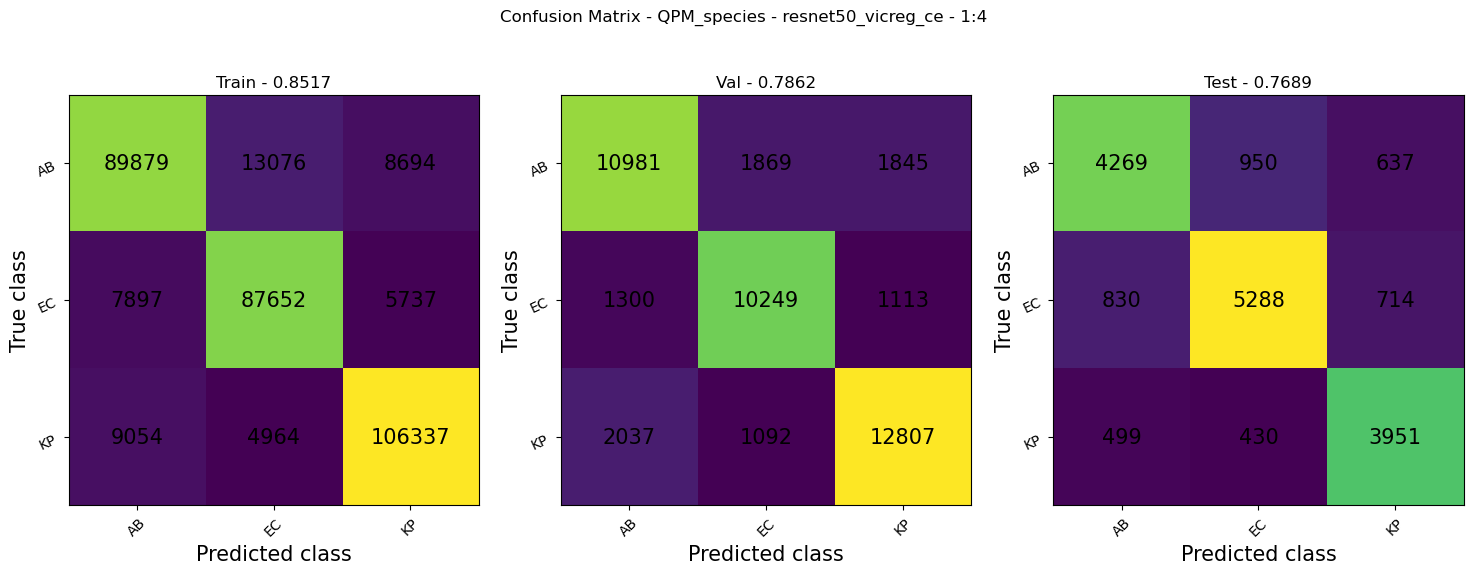

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


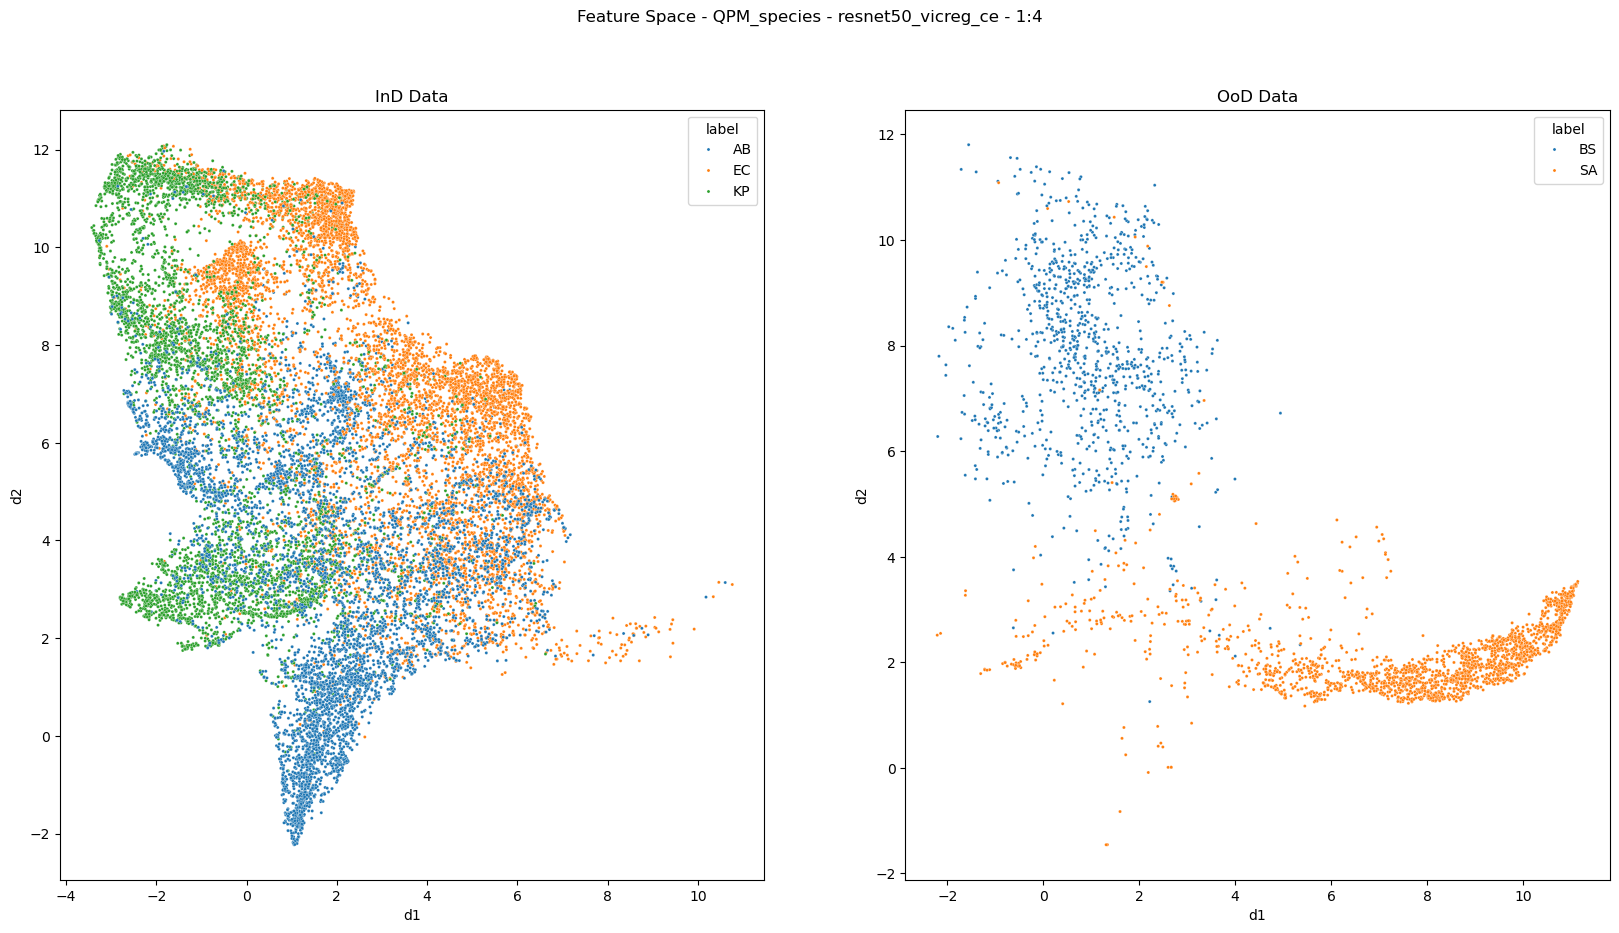

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

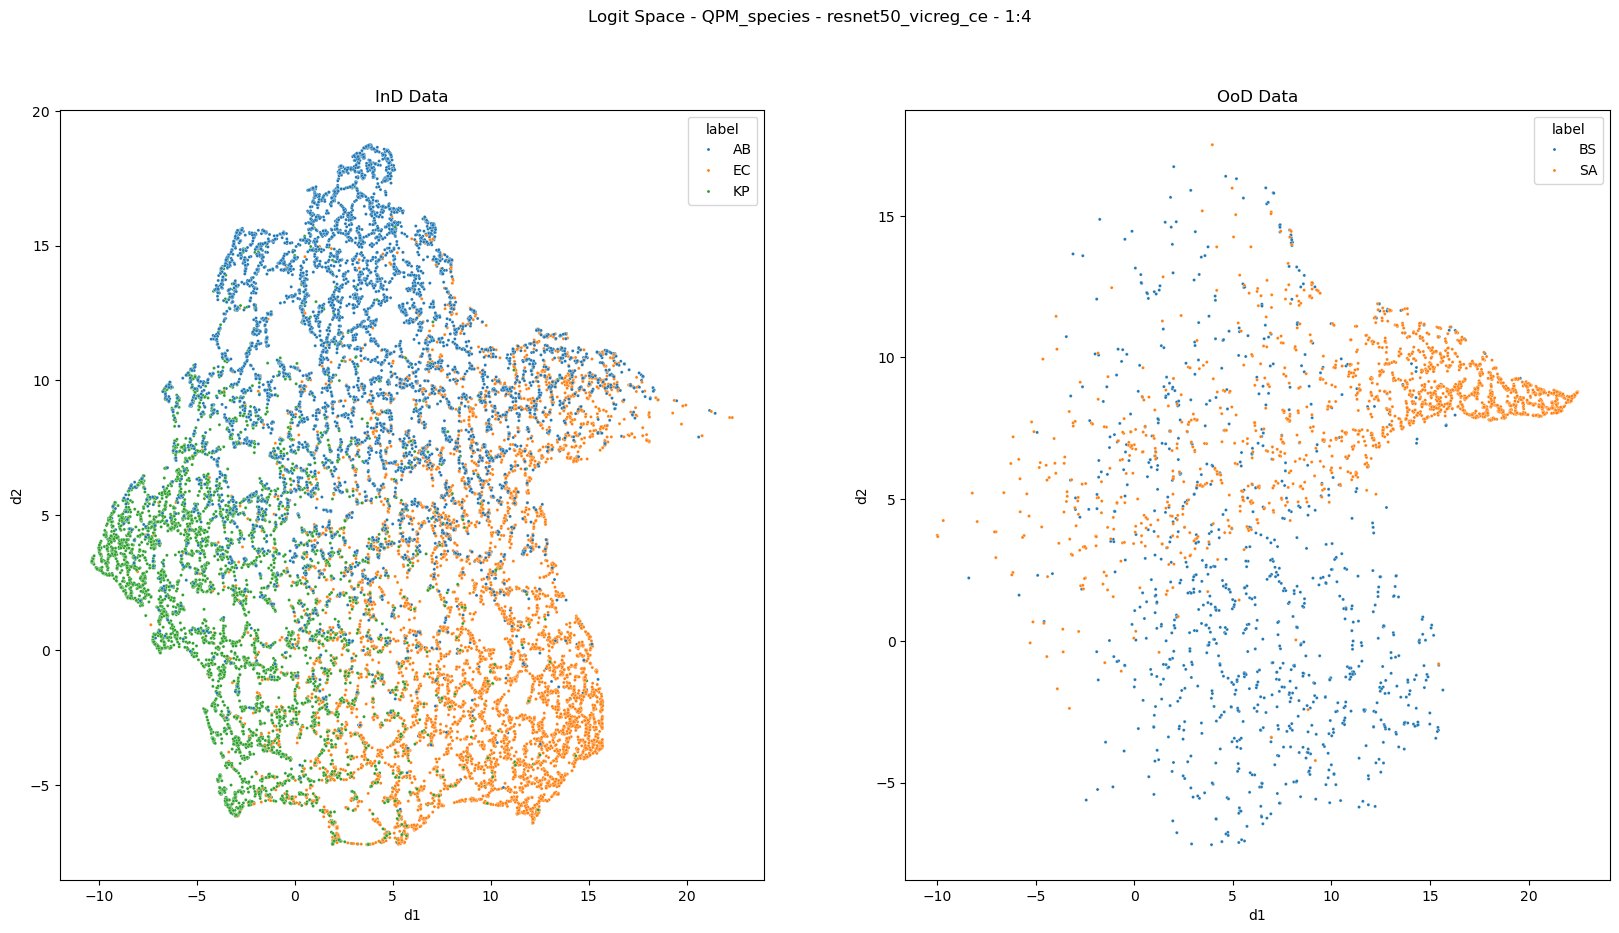

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

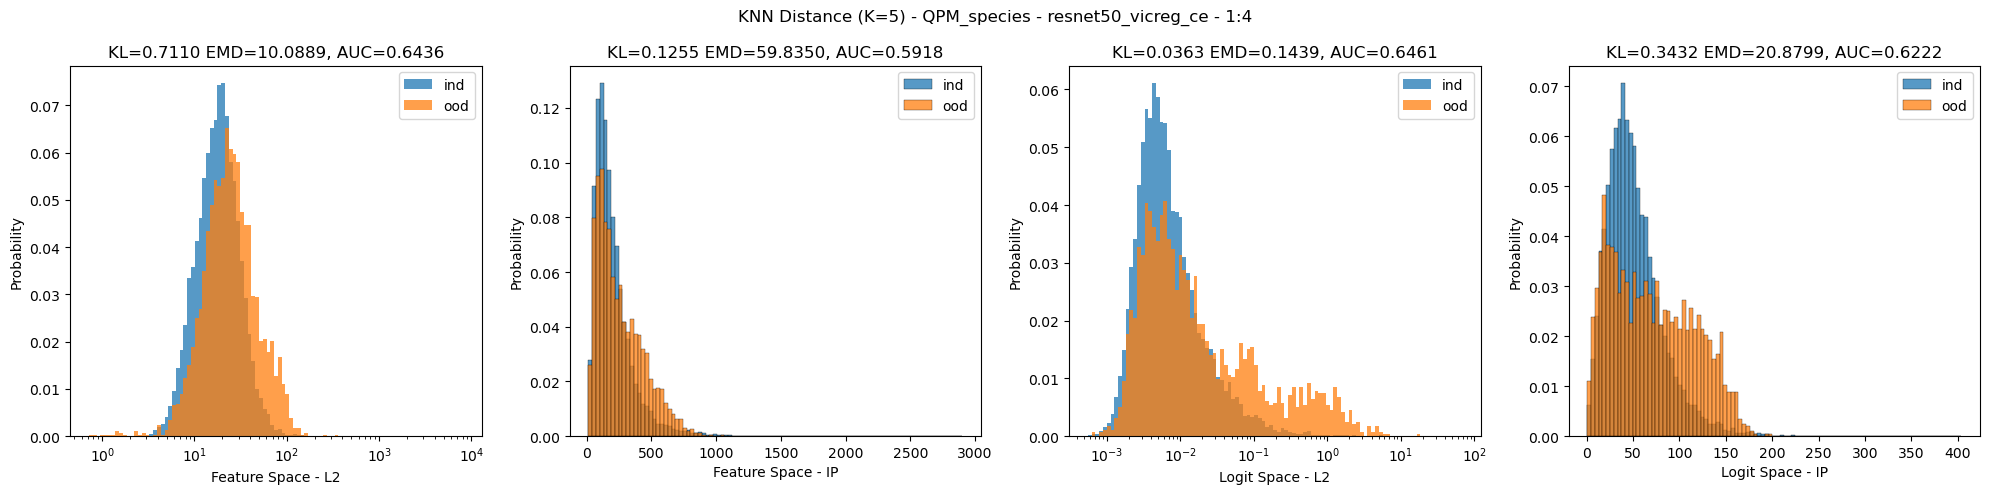

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

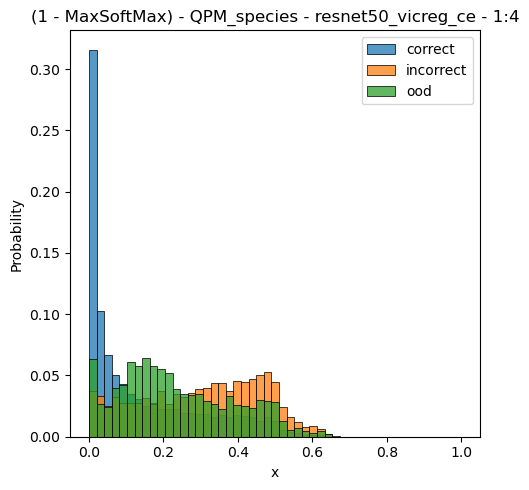

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)